## Imports ##

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from glob import glob
import seaborn as sns

in_path = 'zt-finegrained-dataset/'

## Data Preprocessing ##

In [2]:
def calc_msec(timestring):
    temp = timestring.replace(".", ",").split(":")
    hour = int(temp[0])
    minute = int(temp[1])
    msec = int(temp[2].replace(",", ""))
    return ((hour * 3600000) + (minute * 60000) + msec)

def get_data(srtfile):
    file = open(srtfile, "r", errors="ignore")
    lines = file.readlines()
    file.close()

    lines = [line[0:-1].replace("-->","<>").replace("- ", "") for line in lines if line[:-1]]
    lines[0] = lines[0][-1:]
    
    # get rid of subtitle index
    for idx, line in enumerate(lines):
        if "<>" in line:
            lines.pop(idx - 1)
            
    for idx, line in enumerate(lines):
        lines[idx] = re.sub(r'\([^)]*\)', '', line)
    
    # get dialogue speeds
    dialogue_speed_list = []
    for idx, line in enumerate(lines):
        if "<>" in line:
            next_idx = idx + 1
            while (next_idx < len(lines) and "<>" not in lines[next_idx]): 
                next_idx += 1
            text = " ".join([lines[x] for x in range(idx + 1, next_idx)])
            n_words = len(text.split())

            timestrings = line.split()
            start_sec = calc_msec(timestrings[0]) / 1000
            end_sec = calc_msec(timestrings[2]) / 1000

            dialogue_speed = n_words / (end_sec - start_sec)
            dialogue_speed_list.append(dialogue_speed)
    
    # get text only
    cleanr = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    text_only = [line for line in lines if "<>" not in line]
    text_only = " ".join(text_only)
    text_only = re.sub(cleanr, '', text_only)
    
    # get sentences
    sentences = re.findall(r"[^\.?!]+", text_only)
    sentences = [s for s in sentences if len(s) > 1]
    
    # get sentence lengths
    n_words_per_sent = [len(s) for s in sentences]
    
    # just for clarity
    total_sents_number = len(sentences)
    average_dialogue_speed = np.average(dialogue_speed_list)
    average_words_per_sent = np.average(n_words_per_sent)
            
    return lines, total_sents_number, average_dialogue_speed, average_words_per_sent

# EXAMPLEFILE = 'zt-finegrained-dataset/action/zoolander2.srt'
# ls, tsn, ads, awps = get_data(EXAMPLEFILE)

In [3]:
folders = glob(in_path + "/*")
folders

['zt-finegrained-dataset\\action',
 'zt-finegrained-dataset\\adventure',
 'zt-finegrained-dataset\\comedy',
 'zt-finegrained-dataset\\disaster',
 'zt-finegrained-dataset\\horror',
 'zt-finegrained-dataset\\martialarts',
 'zt-finegrained-dataset\\romance',
 'zt-finegrained-dataset\\scifi',
 'zt-finegrained-dataset\\spy']

In [4]:
movies = []
genres = []
tsn_movies = []
ads_movies = []
awps_movies = []

for folder in folders:
    files = glob(folder + "/*.srt")
    for file in files:        
        genre = file[file.find("\\") + 1:file.rfind("\\")]
        moviename = file[file.rfind("\\") + 1:file.rfind(".srt")]
        _, tsn, ads, awps = get_data(file)
        
        genres.append(genre)
        movies.append(moviename)
        tsn_movies.append(tsn)
        ads_movies.append(ads)
        awps_movies.append(awps)
        
        
genres = pd.DataFrame(genres)
movies = pd.DataFrame(movies)
tsn_movies = pd.DataFrame(tsn_movies)
ads_movies = pd.DataFrame(ads_movies)
awps_movies = pd.DataFrame(awps_movies)

data = pd.concat([movies, genres, tsn_movies, ads_movies, awps_movies], axis=1)
data.columns = ['movie', 'genre', 'total_sent_num', 'avg_dialogue_speed', 'avg_word_per_sent']
data = data.groupby(['movie', 'total_sent_num', 'avg_dialogue_speed', 'avg_word_per_sent']).genre.apply("-".join).reset_index()
data['genre'] = data['genre'].apply(lambda x: x.split('-'))
data

movie  total_sent_num  avg_dialogue_speed  avg_word_per_sent  \
0       100earthquake            1610            2.947354          26.067081   
1                2012            1963            2.717890          29.704534   
2    alitabattleangel            1392            2.713729          24.474856   
3        annihilation            1087            2.723397          24.952162   
4     awalktoremember            1114            1.990317          23.296230   
..                ...             ...                 ...                ...   
105          voyagers            1045            2.472964          26.444976   
106              womb             533            1.842064          23.744841   
107         worldwarz            1452            2.816107          24.564050   
108          zambezia            1351            2.194915          24.203553   
109        zoolander2            1591            2.685414          27.404148   

                 genre  
0           [disaster]  
1    [disaster, scifi]  
2      [action, scifi]  
3      [horror, scifi]  
4            [romance]  
..                 ...  
105            [scifi]  
106            [scifi]  
107   [action, horror]  
108        [adventure]  
109   [action, comedy]  

[110 rows x 5 columns]

In [5]:
data.to_csv("subtitle_sentence_features.csv")

## Grouping & Visualization ##

In [6]:
df = data.copy()
df['genre'] = df['genre'].apply("-".join)
df = df.groupby(['genre']).mean().reset_index()
df

genre  total_sent_num  avg_dialogue_speed  avg_word_per_sent
0               action          1045.0            2.859407          26.737456
1     action-adventure          1411.8            2.822039          25.036968
2        action-comedy          2156.4            3.059372          24.356418
3        action-horror          1299.6            2.716028          25.696240
4   action-martialarts           939.0            2.145861          28.553757
5         action-scifi          1321.0            2.463443          23.443577
6           action-spy          1274.0            2.551589          28.414867
7            adventure          1160.2            2.379586          25.705455
8     adventure-comedy          1731.6            2.441852          23.865951
9               comedy          2128.6            2.827003          25.940644
10       comedy-horror          1610.8            2.564870          25.989423
11  comedy-martialarts          1008.8            2.678386          34.213545
12      comedy-romance          1923.0            2.796554          26.416137
13        comedy-scifi          1825.6            2.679334          31.802721
14          comedy-spy          1614.4            2.579392          29.096790
15            disaster          1691.6            2.661231          24.383507
16      disaster-scifi          1564.2            2.768960          26.028700
17              horror          1063.4            2.612632          24.168961
18        horror-scifi          1014.8            2.619046          25.905115
19             romance          1734.0            2.549952          24.131623
20       romance-scifi          1445.4            2.565816          28.010891
21               scifi          1086.6            2.311827          24.519261

In [7]:
df = df.sort_values(by=['genre'])
df

genre  total_sent_num  avg_dialogue_speed  avg_word_per_sent
0               action          1045.0            2.859407          26.737456
1     action-adventure          1411.8            2.822039          25.036968
2        action-comedy          2156.4            3.059372          24.356418
3        action-horror          1299.6            2.716028          25.696240
4   action-martialarts           939.0            2.145861          28.553757
5         action-scifi          1321.0            2.463443          23.443577
6           action-spy          1274.0            2.551589          28.414867
7            adventure          1160.2            2.379586          25.705455
8     adventure-comedy          1731.6            2.441852          23.865951
9               comedy          2128.6            2.827003          25.940644
10       comedy-horror          1610.8            2.564870          25.989423
11  comedy-martialarts          1008.8            2.678386          34.213545
12      comedy-romance          1923.0            2.796554          26.416137
13        comedy-scifi          1825.6            2.679334          31.802721
14          comedy-spy          1614.4            2.579392          29.096790
15            disaster          1691.6            2.661231          24.383507
16      disaster-scifi          1564.2            2.768960          26.028700
17              horror          1063.4            2.612632          24.168961
18        horror-scifi          1014.8            2.619046          25.905115
19             romance          1734.0            2.549952          24.131623
20       romance-scifi          1445.4            2.565816          28.010891
21               scifi          1086.6            2.311827          24.519261

C:\Users\miche\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


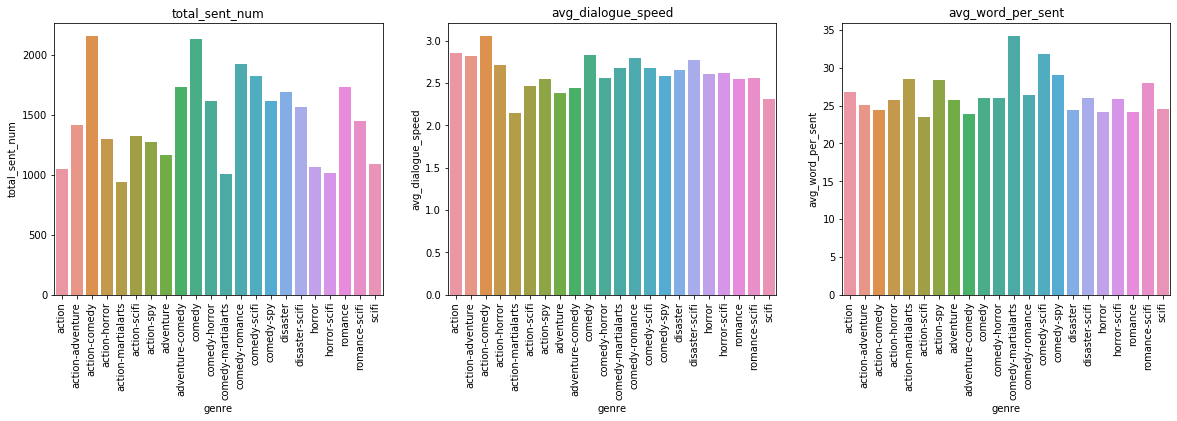

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
p1 = sns.barplot(x=df['genre'], y=df['total_sent_num'], ax=axes[0])
p2 = sns.barplot(x=df['genre'], y=df['avg_dialogue_speed'], ax=axes[1])
p3 = sns.barplot(x=df['genre'], y=df['avg_word_per_sent'], ax=axes[2])
axes[0].tick_params(axis='x', rotation=90)
axes[0].set_title('total_sent_num')
axes[1].tick_params(axis='x', rotation=90)
axes[1].set_title('avg_dialogue_speed')
axes[2].tick_params(axis='x', rotation=90)
axes[2].set_title('avg_word_per_sent')
plt.close(2)
fig.show()